<h1> Brain Tumor Classification (VGG-16) </h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
import random

In [4]:
np.random.seed(1)
tf.random.set_seed(1)

<h2> Split Data </h2>

In [5]:
train_folder = 'D:\\MRI BrainTumor\\Training' 
test_folder = 'D:\\MRI BrainTumor\\Testing'

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224,224),
    batch_size = 32,
    color_mode = 'rgb',
    validation_split= 0.2,
    subset = 'training',
    shuffle = True,
    seed = 1
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [7]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224,224),
    batch_size = 32,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'validation',
    shuffle = True,
    seed = 1
)
    
    
    

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [8]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224,224),
    batch_size = 32,
    color_mode = 'rgb',
    shuffle = False,
    seed = 1
)

Found 1311 files belonging to 4 classes.


In [9]:
train_class_names = train_dataset.class_names
val_class_names = val_dataset.class_names
test_class_names = test_dataset.class_names

<h2> Data Visualization </h2>

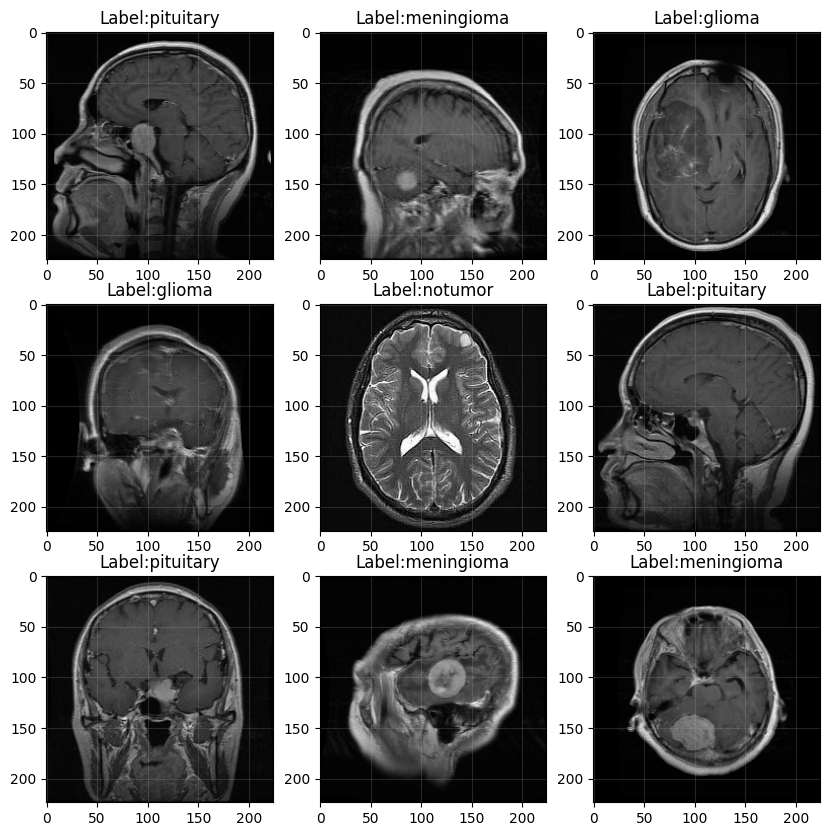

In [10]:
#display few images from dataset

def display_images (dataset, class_names, num_images=9):
    plt.figure(figsize=(10,10))
    for i, (image,label) in enumerate(dataset.take(1)):
        for j in range (num_images):
            plt.subplot(3,3,j+1)
            plt.imshow(image[j].numpy().astype("uint8"))
            label_name = class_names[label [j].numpy()]
            plt.title(f"Label:{label_name}")
            plt.axis("on")
            plt.grid(alpha =0.2)
        plt.show()
        break
display_images(train_dataset, train_class_names)

<h2> Data Preprocessing </h2>

In [11]:
#data augmentation
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, RandomBrightness, RandomContrast, RandomTranslation, GaussianNoise

In [12]:
data_augmentation = tf.keras.Sequential([
    RandomFlip('vertical'),
    RandomFlip('horizontal'),
    RandomZoom(0.3),
    RandomRotation(0.2),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
    RandomBrightness(factor=0.0009),
    RandomContrast(factor=0.0009),
    GaussianNoise(0.1)
])
    

In [13]:
#preprocessing
def preprocess (image,label, training =True):
    if training:
        image = data_augmentation(image)
    image = tf.image.resize(image, (224,224))
    image = image/225
    return image, label

train_dataset_aug = train_dataset.map(lambda x,y:preprocess(x,y,training =True))
val_dataset_aug = val_dataset.map(lambda x,y:preprocess (x,y, training=False))
test_dataset_aug = test_dataset.map(lambda x,y: preprocess (x,y, training = False))

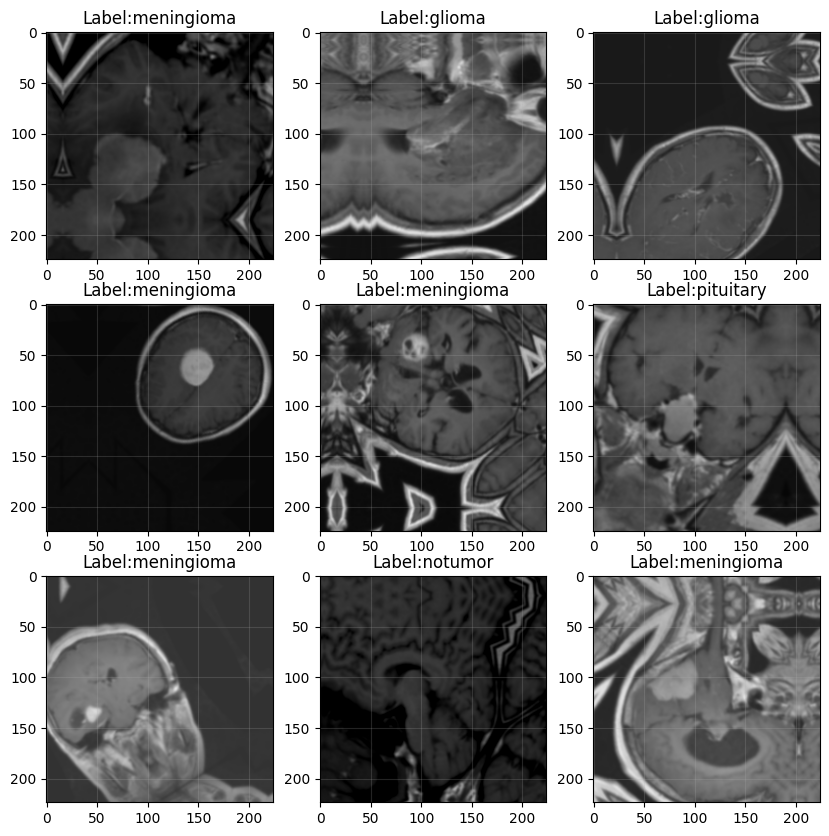

In [14]:
#display augmented dataset

def display_augmented_images (dataset, class_names, num_images = 9):
    plt.figure(figsize=(10,10))
    for i, (image, label) in enumerate(dataset.take(1)):
        for j in range(num_images):
            augmented_image = data_augmentation(image[j:j+1])
            augmented_image = augmented_image[0] *225
            augmented_image = tf.clip_by_value(augmented_image, 0, 225)
            plt.subplot(3,3,j+1)
            plt.imshow(augmented_image.numpy().astype('uint8'))
            label_name = class_names[label[j].numpy()]
            plt.title(f"Label:{label_name}")
            plt.axis('on')
            plt.grid(alpha =0.2)
        plt.show()
        break
display_augmented_images(train_dataset_aug, train_class_names)     
    

<h2> Model Building </h2>

In [15]:
#Build Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Dense
from tensorflow.keras.regularizers import l2

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [17]:
base_model_vgg = VGG16(weights = 'imagenet',
                       include_top = False,
                       input_shape = (224,224,3))

In [35]:
#Freeze all layers
for layer in base_model_vgg.layers:
    layer.trainable = False

In [19]:
model = Sequential([
    base_model_vgg,
    GlobalAveragePooling2D(),
    
    Dense(256, activation = 'relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(train_class_names), activation = 'softmax')
])


In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,068 (56.64 MB)

 Trainable params: 132,868 (519.02 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

<h2> Compile Model </h2>

In [21]:
#compile model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
model.compile(optimizer = 'Adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
             )

In [23]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 6,
    restore_best_weights= True )

In [24]:
#train model
history = model.fit(
    train_dataset_aug,
    validation_data = val_dataset_aug,
    epochs = 25,
    callbacks = [early_stopping]
)

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 756s 5s/step - accuracy: 0.5841 - loss: 1.3602 - val_accuracy: 0.7452 - val_loss: 1.0618
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 599s 4s/step - accuracy: 0.7322 - loss: 0.8926 - val_accuracy: 0.6865 - val_loss: 0.9714
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 592s 4s/step - accuracy: 0.7493 - loss: 0.8143 - val_accuracy: 0.8196 - val_loss: 0.6778
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 595s 4s/step - accuracy: 0.7688 - loss: 0.7336 - val_accuracy: 0.6961 - val_loss: 0.9093
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 594s 4s/step - accuracy: 0.7767 - loss: 0.7212 - val_accuracy: 0.8074 - val_loss: 0.6883
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 595s 4s/step - accuracy: 0.7864 - loss: 0.6932 - val_accuracy: 0.7522 - val_loss: 0.8306
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 594s 4s/step - accuracy: 0.7977 - loss: 0.6487 - val_accuracy: 0.8380 - val_loss: 0.5563
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 593s 4s/step - accuracy: 0.7856 - loss: 0.6651 - val_accu

<h2> Test Accuracy and Loss </h2>

In [25]:
test_loss, test_accuracy = model.evaluate(test_dataset_aug)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.7332 - loss: 0.8652
Test Loss: 0.6818
Test Accuracy: 0.8040


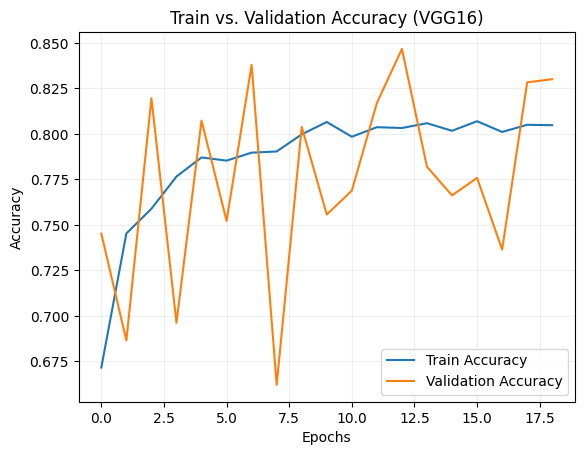

In [26]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Train vs. Validation Accuracy (VGG16)")
plt.legend()
plt.grid(alpha =0.2)
plt.savefig('VGG16 accuracy all layers frozen.png')
plt.show()


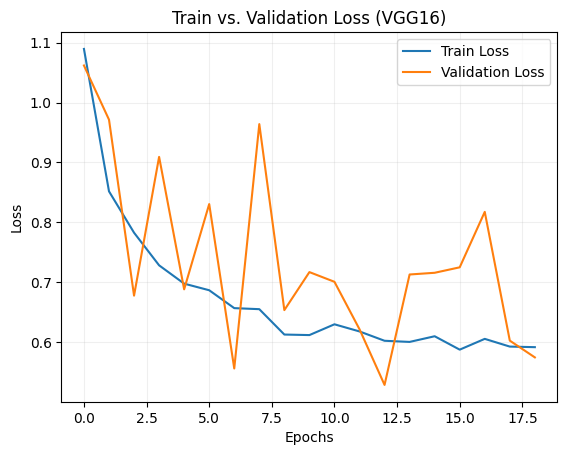

In [27]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(train_loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Train vs. Validation Loss (VGG16)")
plt.legend()
plt.grid(alpha =0.2)
plt.savefig('VGG-16 Loss all layers frozen.png')
plt.show()


<h2> Confusion Matrix </h2>

In [28]:
# Generate predictions
y_pred_probs = model.predict(test_dataset_aug)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)


41/41 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step


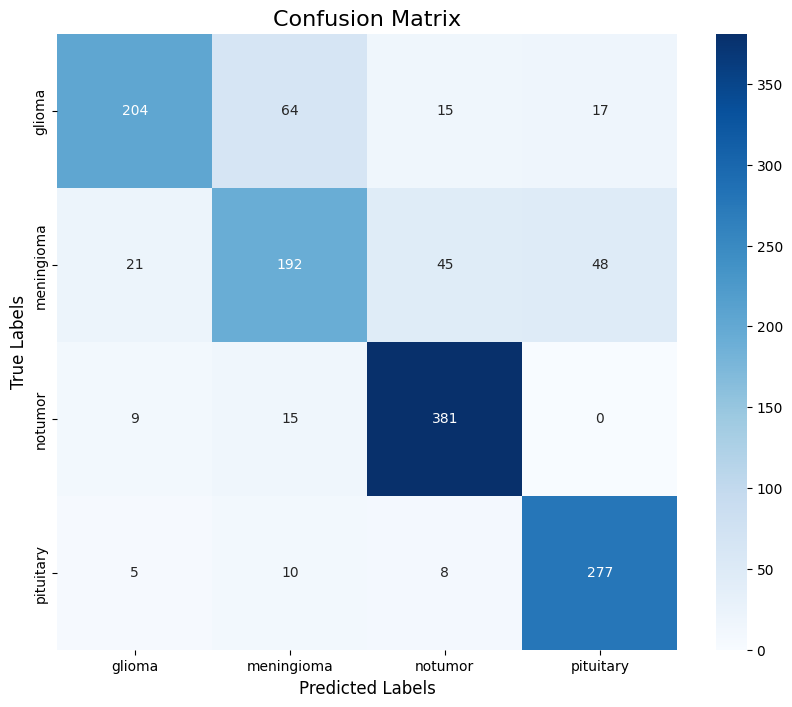

In [29]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_class_names, yticklabels=test_class_names)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.savefig('Confusion Matrix (Vgg16)-all layers frozen)')
plt.show()


<h2> Model Evaluation </h2>

In [32]:
# Extract training history
history_data = history.history  # Access the history attribute

# Compute the mean and standard deviation for loss
train_loss = history_data['loss']
val_loss = history_data['val_loss']

train_loss_mean = np.mean(train_loss)
train_loss_std = np.std(train_loss)
val_loss_mean = np.mean(val_loss)
val_loss_std = np.std(val_loss)

# Compute the confidence interval (95%) for loss
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = np.std(data) / np.sqrt(n)  # Standard Error
    h = se * 1.96  # t-value for 95% CI
    return mean - h, mean + h

# Confidence interval for training and validation loss
train_loss_ci = confidence_interval(train_loss)
val_loss_ci = confidence_interval(val_loss)

print(f"Train Loss - Mean: {train_loss_mean:.4f}, Std: {train_loss_std:.4f}, 95% CI: {train_loss_ci}")
print(f"Validation Loss - Mean: {val_loss_mean:.4f}, Std: {val_loss_std:.4f}, 95% CI: {val_loss_ci}")

# Compute the mean and standard deviation for accuracy
train_accuracy = history_data['accuracy']
val_accuracy = history_data['val_accuracy']

train_acc_mean = np.mean(train_accuracy)
train_acc_std = np.std(train_accuracy)
val_acc_mean = np.mean(val_accuracy)
val_acc_std = np.std(val_accuracy)

# Compute the confidence interval (95%) for accuracy
train_acc_ci = confidence_interval(train_accuracy)
val_acc_ci = confidence_interval(val_accuracy)

print(f"Train Accuracy - Mean: {train_acc_mean:.4f}, Std: {train_acc_std:.4f}, 95% CI: {train_acc_ci}")
print(f"Validation Accuracy - Mean: {val_acc_mean:.4f}, Std: {val_acc_std:.4f}, 95% CI: {val_acc_ci}")

Train Loss - Mean: 0.6744, Std: 0.1199, 95% CI: (0.6204905716162795, 0.7283064108979512)
Validation Loss - Mean: 0.7385, Std: 0.1462, 95% CI: (0.6727370382853438, 0.8042257978798334)
Train Accuracy - Mean: 0.7864, Std: 0.0316, 95% CI: (0.7722059234770327, 0.8006606041807272)
Validation Accuracy - Mean: 0.7746, Std: 0.0518, 95% CI: (0.7513628488573826, 0.797904374149418)


<h2> Confusion Matrix </h2>

In [33]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


# Predicting on the training data
train_true_labels = []
train_pred_labels = []

for images, labels in train_dataset_aug:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class
    train_true_labels.extend(labels.numpy())  # True labels
    train_pred_labels.extend(predicted_labels)  # Predicted labels

# Predicting on the validation data
val_true_labels = []
val_pred_labels = []

for images, labels in val_dataset_aug:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class
    val_true_labels.extend(labels.numpy())  # True labels
    val_pred_labels.extend(predicted_labels)  # Predicted labels

# Calculate F1 score for training data
train_f1_score = f1_score(train_true_labels, train_pred_labels, average='weighted')  # Use 'weighted' for class imbalance
# Calculate F1 score for validation data
val_f1_score = f1_score(val_true_labels, val_pred_labels, average='weighted')  # Use 'weighted' for class imbalance

print(f"Training F1 Score: {train_f1_score:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")

# You can also print a full classification report with precision, recall, and F1 for each class
print("\nClassification Report for Training Data:")
print(classification_report(train_true_labels, train_pred_labels, target_names=train_class_names))

print("\nClassification Report for Validation Data:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

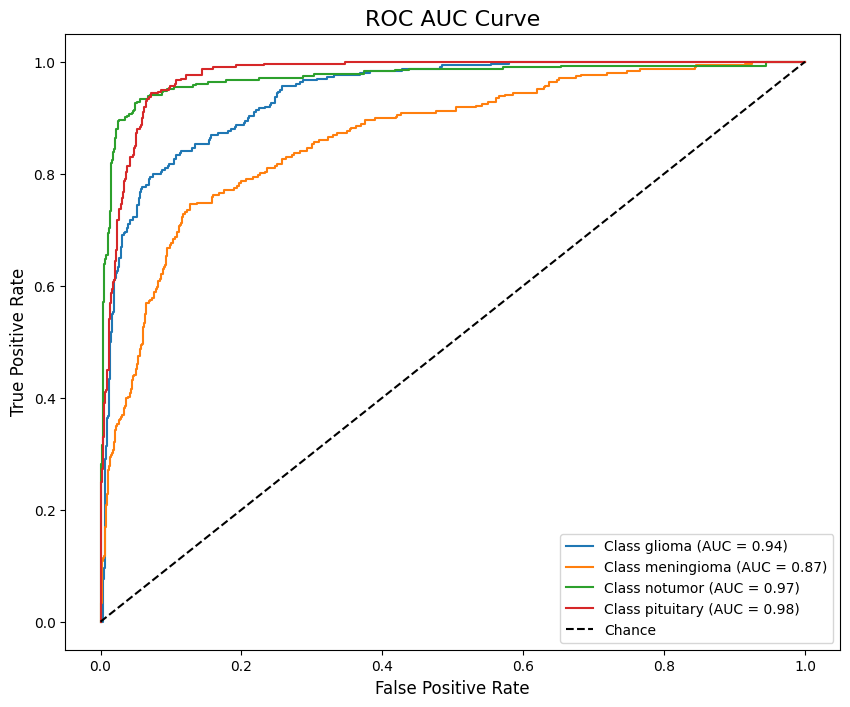

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get true labels and predictions
y_true = []
y_pred_proba = []

for images, labels in test_dataset_aug:
    y_true.extend(labels.numpy())
    y_pred_proba.extend(model.predict(images))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Binarize the labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=range(len(test_class_names)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(test_class_names):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Add labels and legend
plt.title('ROC AUC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid
plt.savefig('ROC AUC Curve (VGG-16 all frozen layer)')
plt.show()


In [30]:
from tensorflow.keras.preprocessing import image


# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    # Load image in grayscale mode and resize
    img = image.load_img(img_path, target_size=(224, 224), color_mode="rgb")
    
    # Convert image to numpy array and expand dimensions to match model input shape
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0) 
    
    # Normalize image values to [0, 1]
    img_array = img_array / 255.0
    
    return img_array

# Function to predict the class of the image
def predict_image(model, img_array, class_names):
    # Get model predictions (probabilities)
    predictions = model.predict(img_array)
    
    # Get the predicted class label (index of the highest probability)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    
    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_idx]
    
    return predicted_class_name, predictions[0][predicted_class_idx]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Predicted Class: notumor
Prediction Probability: 0.6282


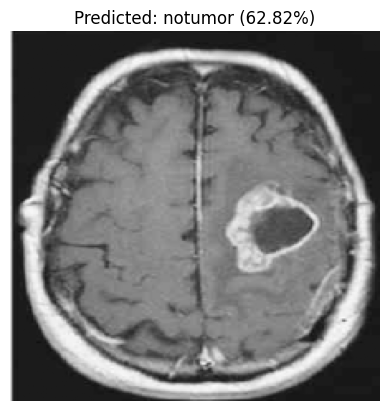

In [31]:
# Load and preprocess the image
img_path = 'D:\\Datasets\\new data\\blastoG.png'  # Provide the path to the MRI image
processed_image = load_and_preprocess_image(img_path)

# Predict the class
predicted_class_name, predicted_prob = predict_image(model, processed_image, test_class_names)

# Display the result
print(f"Predicted Class: {predicted_class_name}")
print(f"Prediction Probability: {predicted_prob:.4f}")

# Display the image and prediction
plt.imshow(processed_image[0].squeeze())  # Use cmap="gray" for grayscale images
plt.title(f"Predicted: {predicted_class_name} ({predicted_prob*100:.2f}%)")
plt.axis('off')
plt.show()
